In [2]:
# === Imports ===
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [3]:
# === Data Loading and Preprocessing ===
print("=== Data Loading and Preprocessing ===")
# Load the tab-separated data
df = pd.read_csv("D:/GIT/Enzyme Classification/Data/Enzyme Data New.tsv", sep='\t')
print(f"Loaded {len(df)} entries from Enzyme Data")

=== Data Loading and Preprocessing ===
Loaded 205003 entries from Enzyme Data


In [4]:
# === Helper Function ===
def extract_class(ec_number):
    """Extract the enzyme class (first digit) from the EC number."""
    if pd.isna(ec_number):
        return np.nan
    # Convert to string and then split
    return int(str(ec_number).split('.')[0])

# Mapping of EC classes to names and functions
ec_class_info = {
    1: {"name": "Oxidoreductases", "function": "Catalyze oxidation-reduction reactions"},
    2: {"name": "Transferases", "function": "Transfer functional groups"},
    3: {"name": "Hydrolases", "function": "Catalyze hydrolysis of various bonds"},
    4: {"name": "Lyases", "function": "Catalyze the breaking of various bonds by means other than hydrolysis and oxidation"},
    5: {"name": "Isomerases", "function": "Catalyze isomerization changes within a single molecule"},
    6: {"name": "Ligases", "function": "Join two molecules with covalent bonds"}
}

def get_class_info(class_number):
    """Get the name and function of the enzyme class."""
    info = ec_class_info.get(class_number, {"name": "Unknown", "function": "Unknown"})
    return info["name"], info["function"]

In [5]:
# Extract class labels from EC number
df['Class'] = df['EC number'].apply(extract_class)

In [6]:
# Validate class labels (should be between 1 and 6)
valid_classes = df['Class'].between(1, 6)
if not valid_classes.all():
    invalid = df[~valid_classes]
    df = df[valid_classes]

print(f"Warning: Found {len(invalid)} with invalid class labels")
print(f"After validation, {len(df)} entries remain")

After validation, 15615 entries remain


In [8]:
# Filter sequences with length >= 3 (required for 3-mers)
df = df[df['Sequence'].apply(len) >= 3]
print(f"After filtering short sequences, {len(df)} entries remain")

After filtering short sequences, 15615 entries remain



=== Exploratory Data Analysis ===


C:\Users\devpa\AppData\Local\Temp\ipykernel_30656\1669971321.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


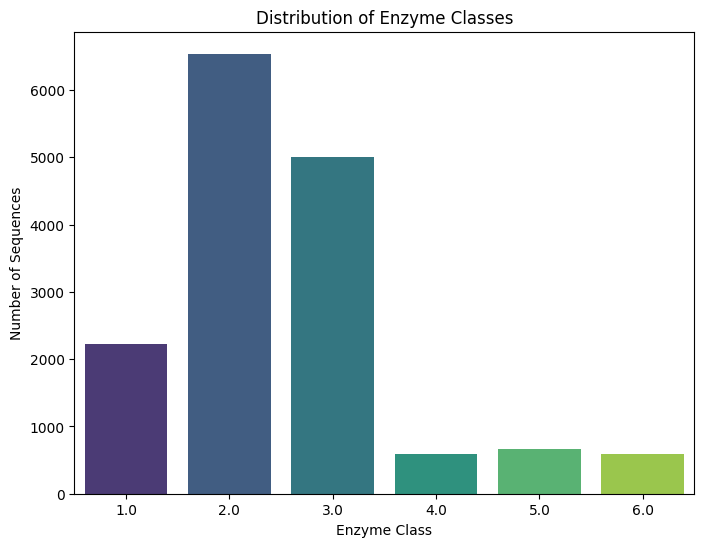

Class distribution plot displayed


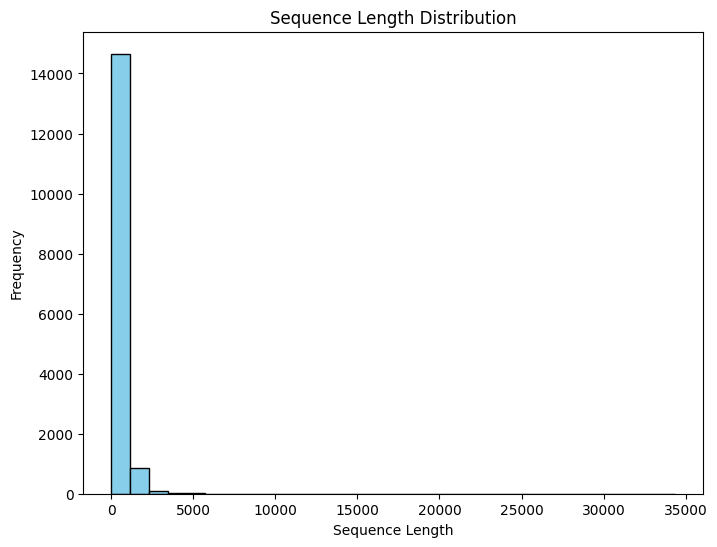

Sequence length distribution plot displayed


In [9]:
# === Exploratory Data Analysis (EDA) ===
print("\n=== Exploratory Data Analysis ===")
# Class distribution
class_counts = df['Class'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Distribution of Enzyme Classes')
plt.xlabel('Enzyme Class')
plt.ylabel('Number of Sequences')
plt.show()
print("Class distribution plot displayed")

# Sequence length distribution
seq_lengths = df['Sequence'].apply(len)
plt.figure(figsize=(8, 6))
plt.hist(seq_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title('Sequence Length Distribution')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()
print("Sequence length distribution plot displayed")

In [10]:
# === Data Splitting ===
print("\n=== Data Splitting ===")
X = df['Sequence']
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")


=== Data Splitting ===
Training set size: 12492
Testing set size: 3123


In [11]:
# === Feature Extraction ===
print("\n=== Feature Extraction ===")
# Initialize CountVectorizer for 3-mer frequencies
vectorizer = CountVectorizer(analyzer='char', ngram_range=(3, 3), lowercase=False)

# Fit vectorizer on training data only to avoid data leakage
vectorizer.fit(X_train)
print(f"Feature vocabulary size: {len(vectorizer.vocabulary_)} 3-mers")

# Transform sequences to count matrices
X_train_counts = vectorizer.transform(X_train)
X_test_counts = vectorizer.transform(X_test)

# Normalize counts to frequencies (divide by number of 3-mers in each sequence)
X_train_freq = X_train_counts / X_train_counts.sum(axis=1)
X_test_freq = X_test_counts / X_test_counts.sum(axis=1)
print("Feature matrices created with 3-mer frequencies")


=== Feature Extraction ===
Feature vocabulary size: 8872 3-mers
Feature matrices created with 3-mer frequencies


In [12]:
# === Model Training ===
print("\n=== Model Training ===")
clf = RandomForestClassifier(random_state=42, n_jobs=-1)  # Use all CPU cores
clf.fit(X_train_freq, y_train)
print("Random Forest model trained successfully")


=== Model Training ===
Random Forest model trained successfully



=== Model Evaluation ===
Accuracy: 0.8646
Macro F1-score: 0.8503
Confusion Matrix:
[[ 337   84   24    0    0    0]
 [   1 1249   56    0    1    1]
 [   0  156  846    0    0    0]
 [   0   28   10   79    0    0]
 [   0   14    9    0  110    0]
 [   0   25   14    0    0   79]]


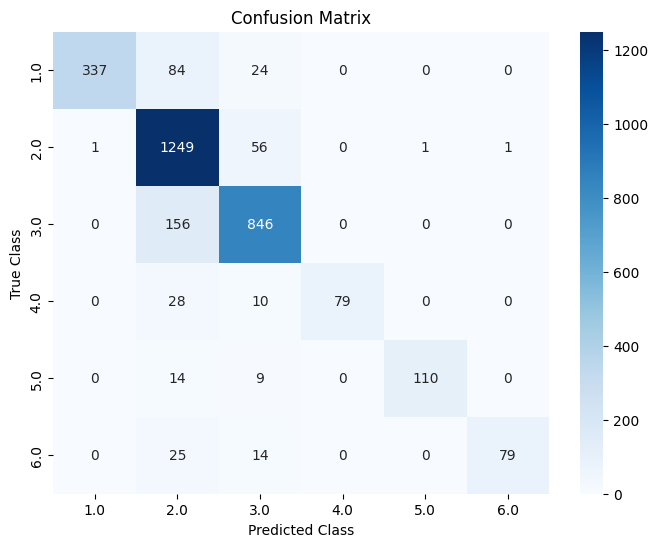

Confusion matrix plot displayed


In [13]:
# === Model Evaluation ===
print("\n=== Model Evaluation ===")
y_pred = clf.predict(X_test_freq)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
cm = confusion_matrix(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1-score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(set(y)), yticklabels=sorted(set(y)))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()
print("Confusion matrix plot displayed")

In [14]:
# === Save Model and Vectorizer ===
print("\n=== Saving Model and Vectorizer ===")
joblib.dump(clf, "D:/GIT/Enzyme Classification/Model/model.pkl")
joblib.dump(vectorizer, "D:/GIT/Enzyme Classification/Model/vectorizer.pkl")
print("Model saved as 'model.pkl' and vectorizer saved as 'vectorizer.pkl'")


=== Saving Model and Vectorizer ===
Model saved as 'model.pkl' and vectorizer saved as 'vectorizer.pkl'


In [15]:
# === Prediction Function ===
def predict_class(sequence, vectorizer, model):
    """Predict the enzyme class, name, and function for a given protein sequence."""
    if len(sequence) < 3:
        raise ValueError("Sequence must be at least 3 amino acids long")
    counts = vectorizer.transform([sequence])
    freq = counts / counts.sum(axis=1)
    class_number = model.predict(freq)[0]
    class_name, class_function = get_class_info(class_number)
    return {
        "class_number": class_number,
        "class_name": class_name,
        "major_function": class_function
    }

In [17]:
# === Test Prediction ===
print("\n=== Testing Prediction ===")
sample_sequence = "MAAAMDVDTPSGTNSGAGKKRFEVKKWNAVALWAWDIVVDNCAICRNHIMDLCIECQANQASATSEECTVAWGVCNHAFHFHCISRWLKTRQVCPLDNREWEFQKYGH"
predicted_info = predict_class(sample_sequence, vectorizer, clf)
print(f"Sample sequence: {sample_sequence[:50]}... (length: {len(sample_sequence)})")
print(f"Predicted class: {predicted_info['class_number']} ({predicted_info['class_name']})")
print(f"Major function: {predicted_info['major_function']}")


=== Testing Prediction ===
Sample sequence: MAAAMDVDTPSGTNSGAGKKRFEVKKWNAVALWAWDIVVDNCAICRNHIM... (length: 108)
Predicted class: 2.0 (Transferases)
Major function: Transfer functional groups
